In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from simulation_functions import kang_shafer_data
import treatment_computing

shap.initjs()
%matplotlib inline

# Functions

# Simulate data

In [2]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform


def plot_calibration_curve(y_true, probs, ax=None, label_head='', n_bins=10,
                           hist=True, normalize=False, color='b'):
    """
    Plot a calibration curve
    
    Parameters
    ----------
    y_true : True labels
    probs: probabilites for the positive class. get for example like this: probs = lr.predict_proba(X_train)[:, 1]
    n_bins: number of bins for histograms
        
    Returns
    -------
    ax: axes of calibration curve
    
    """
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=n_bins, normalize=normalize)

    label=''
    LABEL_SZ = 10
    TITLE_SZ = 12
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(6,5))
    if hist:
        ids_positive = np.where((y_true==1))
        ids_negative = np.where((y_true==0))
        probs_pos = probs[ids_positive]
        probs_neg = probs[ids_negative]
        weights=[np.ones_like(probs_pos)/len(probs), np.ones_like(probs_neg)/len(probs)]
        ax.hist(probs_pos,  bins=bins, weights=weights[0],
                color='r', alpha=0.4, histtype='bar', stacked=True);
        ax.hist(probs_neg,  bins=bins, weights=weights[1],
                color='b', alpha=0.4, histtype='bar', stacked=True, hatch='.');
        
    ax.plot([0, 1], [0, 1], ':', c='k')
    ax.plot(prob_pred, prob_true, marker="o", label=label, color=color)
    ax.set_xlabel('Predicted probability (#bins='+str(n_bins)+')', size=LABEL_SZ)
    ax.set_ylabel('Fraction of positive samples', size=LABEL_SZ)
    ax.set_title('Calibration curve', size=TITLE_SZ)
    ax.grid()
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0,1.01,0.1))
    xticklabels = [str(i)+'%' for  i in np.arange(0,101,10)] 
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(np.arange(0,1.01,0.1))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    return(ax)

In [3]:
from simulation_functions import kang_shafer_data

X1, X2, X3, X4, A, Y_true = kang_shafer_data(size=(5000,), X_observed=True)

X = pd.DataFrame(data=np.transpose(np.vstack((X1,X2,X3,X4))), columns=['X1', 'X2', 'X3', 'X4'])
T = pd.Series(data=A)
Y = pd.Series(data=Y_true)

# On Covariates

## Propensity score matching

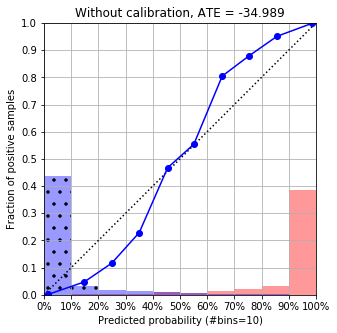

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

CLF = GradientBoostingClassifier(max_depth=3)
clf = CLF.fit(X, T)

propensity_scores, ret = treatment_computing.propensity_score_l1_based(clf, X, T, Y)

fig, ax = plt.subplots(1,1,figsize=(6,5))
plot_calibration_curve(T, propensity_scores, ax=ax, n_bins=10);
ax.set_title('Without calibration, ATE = {:.3f}'.format(ret['ATE']));

## Nearest Neighbour Matching

In [5]:
ATE = treatment_computing.nearest_neighbors_based(X, T, Y)['ATE']
print(ATE)

-14.920039409992826


## Mahanabolis matching

In [6]:
ATE = treatment_computing.mahanabolis_matching_based(X, T, Y)['ATE']
print(ATE)

-18.264508864727386


# On SHAP_T

## Calculate SHAP_T

In [7]:
CLF = GradientBoostingClassifier(max_depth=3)
clf = CLF.fit(X, T)

explainer = shap.TreeExplainer(clf)
shap_T =  explainer.shap_values(X)
shap_T = pd.DataFrame(data=shap_T, index=X.index, columns=X.columns)

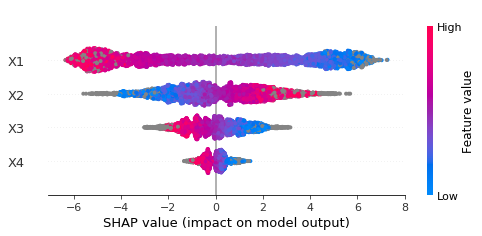

In [8]:
shap.summary_plot(shap_T.values, X)

## Nearest Neighbour Matching

In [9]:
ATE = treatment_computing.nearest_neighbors_based(shap_T, T, Y)['ATE']
print(ATE)

-14.790841286708664


## Mahanabolis matching

In [10]:
ATE = treatment_computing.mahanabolis_matching_based(shap_T, T, Y)['ATE']
print(ATE)

-18.74772612000596


# SHAP_T and SHAP_Y

In [11]:
X_T = pd.concat([X,T.rename('T')], axis=1)

In [12]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor


CLF_T = GradientBoostingClassifier(max_depth=3)
clf_T = CLF_T.fit(X, T)

explainer_T = shap.TreeExplainer(clf_T)
shap_T =  explainer_T.shap_values(X)
shap_T = pd.DataFrame(data=shap_T, index=X.index, columns=X.columns)


CLF_Y = GradientBoostingRegressor(max_depth=3)
clf_Y = CLF_Y.fit(X_T, Y)

explainer_Y = shap.TreeExplainer(clf_Y)
shap_Y =  explainer_Y.shap_values(X_T)
shap_Y = pd.DataFrame(data=shap_Y, index=X_T.index, columns=X_T.columns)

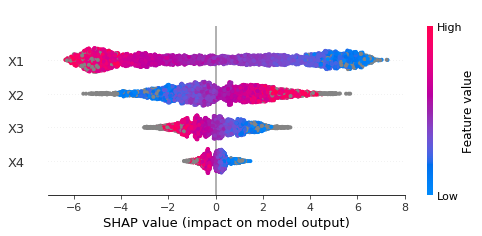

In [13]:
shap.summary_plot(shap_T.values, X)

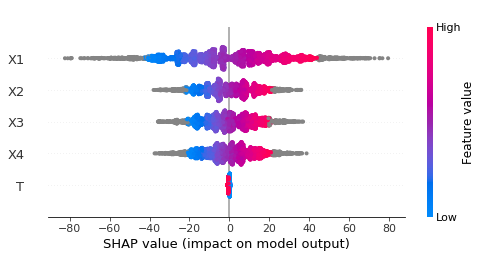

In [14]:
shap.summary_plot(shap_Y.values, X_T)

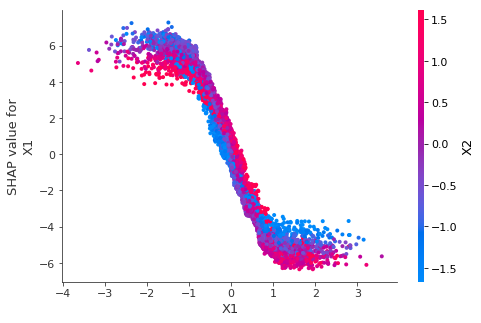

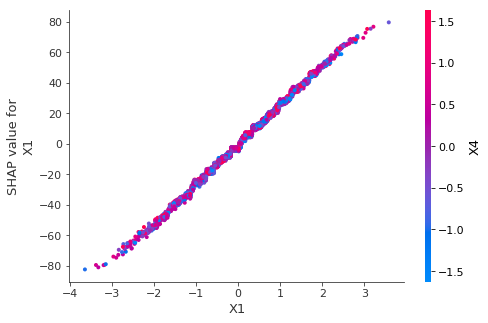

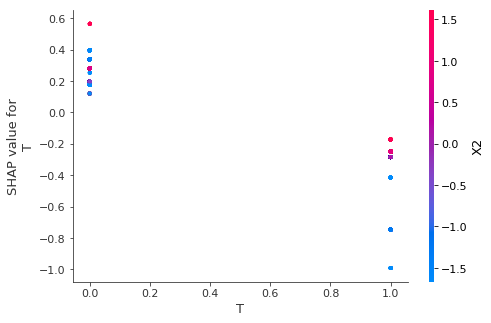

In [15]:
# plt.figure(figsize=(10,4))

shap.dependence_plot('X1', shap_T.values, X)
shap.dependence_plot('X1', shap_Y.values, X_T)
shap.dependence_plot('T', shap_Y.values, X_T)

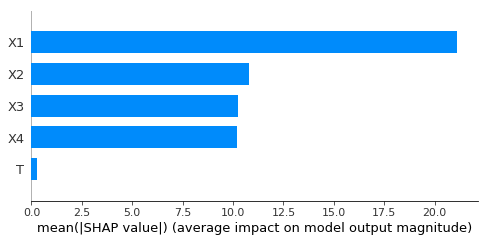

In [16]:
shap.summary_plot(shap_Y.values, X_T, plot_type='bar')

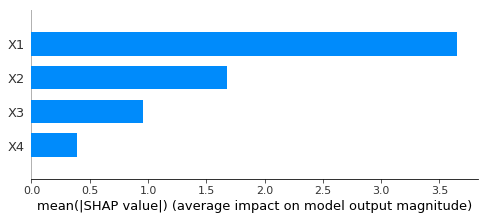

In [17]:
shap.summary_plot(shap_T.values, X, plot_type='bar')

In [18]:
np.mean(shap_T.abs())

X1    3.648004
X2    1.677487
X3    0.960208
X4    0.387495
dtype: float64

In [19]:
def make_mean_shap_df(shap_T, shap_Y):
    # Make df
    mean_shap_df = pd.DataFrame(data={
                                     'mean_abs_shap_T':np.mean(shap_T.abs()),
                                     'mean_abs_shap_Y':np.mean(shap_Y.abs())
                                    })

    # fractions
    mean_shap_df['fraction_mean_abs_shap_T'] = mean_shap_df['mean_abs_shap_T'] / mean_shap_df['mean_abs_shap_T'].sum()
    mean_shap_df['fraction_mean_abs_shap_Y'] = mean_shap_df['mean_abs_shap_Y'] / mean_shap_df['mean_abs_shap_Y'].sum()

    # rank
    mean_shap_df['rank_mean_abs_shap_T'] = mean_shap_df['fraction_mean_abs_shap_T'].rank(ascending=False)
    mean_shap_df['rank_mean_abs_shap_Y'] = mean_shap_df['fraction_mean_abs_shap_Y'].rank(ascending=False)


    # sort
    mean_shap_df.sort_values(['fraction_mean_abs_shap_T'], ascending=False, inplace=True)
    
    return mean_shap_df

In [20]:
mean_shap_df = make_mean_shap_df(shap_T, shap_Y)

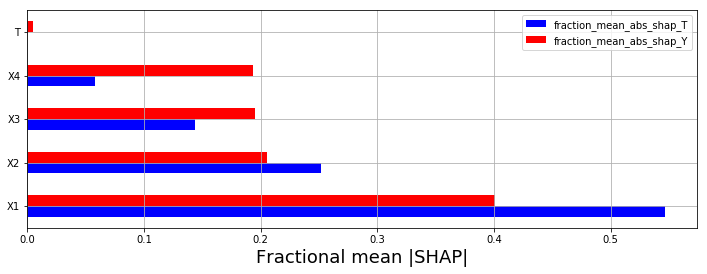

In [21]:
col_header = 'fraction_mean_abs_shap'

fig, ax = plt.subplots(1,1,figsize=(12,4))
mean_shap_df[[col_header+'_T', col_header+'_Y']].plot(kind='barh', color=['blue', 'red'], ax=ax)

ax.set_xlabel('Fractional mean |SHAP|', size=18);
ax.grid();

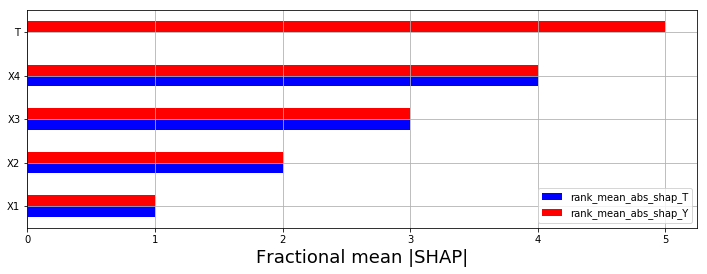

In [22]:
col_header = 'rank_mean_abs_shap'

fig, ax = plt.subplots(1,1,figsize=(12,4))
mean_shap_df[[col_header+'_T', col_header+'_Y']].plot(kind='barh', color=['blue', 'red'], ax=ax)

ax.set_xlabel('Fractional mean |SHAP|', size=18);
ax.grid();